In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime

import matplotlib.pyplot as plt

%matplotlib inline

### Modifications
 * fixed SNR threshold is replased with automatic 
 * save/load binarized expression matrices

In [2]:
min_n_samples = -1
alpha = 0.1
beta_K = 100.0
snr_pval = 0.05 
f = 0.25 # min % of time in a module


# convergence
max_n_steps= 100
n_steps_averaged = 10
n_points_fit=20
n_steps_for_convergence = 10


verbose = True
plot_all = True


load_binarized_exprs = True
out_dir = os.getcwd()+"/tmp_results/"
basename = "TCGA-micro_13K"
seed = 42

root = "/home/olya/SFU/Breast_cancer/"

exprs_file = root+"/Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"

In [3]:
start_time = time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
if verbose:
    print("Will save output files to:",out_dir + basename + "*", file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# define minimal number of patients in a module
if min_n_samples == -1:
    min_n_samples = int(max(5,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
if verbose:
    print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)

Will save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-micro_13K*
Mininal number of samples in a module: 26


# 0) Find the trend between SNR and bicluster size

1) generate random splits for all bicluster sizes [min_n_samples, N/2]

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.05

get_snr_thr is a function of bicluser size 


In [4]:
if not load_binarized_exprs:
    from method2 import rand_norm_splits, get_trend
    
    sizes,thresholds = rand_norm_splits(exprs.shape[1], snr_pval = snr_pval,seed=seed)
    get_min_snr = get_trend(sizes,thresholds, plot = plot_all)


# 1) Assign patients to edges
 * GMM
 * filtering by sample nubmer and SNR

In [5]:
if not load_binarized_exprs:
    from method2 import GM_binarization
    sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
    binarized_expressions = GM_binarization(exprs,get_min_snr,min_n_samples,verbose = True, 
                                        plot=True, plot_SNR_thr= 3.0, show_fits = sele_genes,seed = seed)
    
    # save to file binarized genes
    sample_names = exprs.columns
    for d in ["UP","DOWN"]:
        df = binarized_expressions[d]
        df.index = sample_names
        suffix  = ".pv="+str(snr_pval)+",direction="+d
        fname = out_dir+"/"+basename+ suffix +".bin_exprs.tsv"
        print("Binarized gene expressions are saved to",fname,file = sys.stdout)
        df.to_csv(fname, sep ="\t")

In [6]:
if load_binarized_exprs:
    # load from file binarized genes
    binarized_expressions = {}

    for d in ["UP","DOWN"]:
        suffix  = ".pv="+str(snr_pval)+",direction="+d
        fname = out_dir+"/"+basename+ suffix +".bin_exprs.tsv"
        print("Uses binarized gene expressions from",fname,file = sys.stdout)
        df = pd.read_csv(fname, sep ="\t",index_col=0)
        df.index = range(0,df.shape[0])
        binarized_expressions[d] = df

Uses binarized gene expressions from /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-micro_13K.pv=0.05,direction=UP.bin_exprs.tsv
Uses binarized gene expressions from /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-micro_13K.pv=0.05,direction=DOWN.bin_exprs.tsv


# Step 2. Sample module memberships

In [7]:
from method2 import set_initial_conditions, sampling, get_consensus_modules

In [8]:
direction = "UP"
exprs_bin = binarized_expressions[direction]
print(exprs_bin.shape)

(529, 1563)


In [9]:
# simplifying probability calculations
N = exprs.shape[1]
max_log_float = np.log(np.finfo(np.float64).max)
n_exp_orders = 7 # ~1000 times 
p0 = N*np.log(0.5)+np.log(beta_K)
match_score = np.log((alpha*0.5+1)/(alpha))
mismatch_score = np.log((alpha*0.5+0)/alpha)
bK_1 = math.log(1+beta_K)
genes = exprs_bin.columns.values

In [10]:
print("Direction:",direction)
moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = True)
K = len(moduleSizes)
N = gene2Samples.shape[1]
print("\t\tLP memory, {:.2f} M".format(LP.nbytes/(1024*1024)),file = sys.stdout)


Direction: UP
		KxN=1563x529
		p0= -362.06968833022296
	 1000 genes processed in  3.3 s
time:	Initial state created in 3.6 s.
		LP memory, 18.64 M


In [11]:
t0 = time()
gene2Module_history,sampling_steps,n_skipping_genes = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score, bK_1, alpha, beta_K, 
                                                                          max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, tol = 0.1, 
                                                                          n_steps_for_convergence = n_steps_for_convergence, verbose=True)

print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time()-t0,2)), file = sys.stdout)


step 1
1000 		genes processed in 10.6 s runtime...
	step  1 15.8 s
step 2
1000 		genes processed in 5.0 s runtime...
	step  2 7.7 s
step 3
1000 		genes processed in 4.2 s runtime...
	step  3 6.5 s
step 4
1000 		genes processed in 4.6 s runtime...
	step  4 6.4 s
step 5
1000 		genes processed in 4.3 s runtime...
	step  5 6.9 s
step 6
1000 		genes processed in 4.4 s runtime...
	step  6 7.2 s
step 7
1000 		genes processed in 3.7 s runtime...
	step  7 5.9 s
step 8
1000 		genes processed in 3.9 s runtime...
	step  8 5.8 s
step 9
1000 		genes processed in 3.6 s runtime...
	step  9 5.2 s
step 10
1000 		genes processed in 3.0 s runtime...
	step  10 4.6 s
step 11
1000 		genes processed in 3.5 s runtime...
	step  11 5.7 s
Genes skipping in last 10 steps: 263
step 12
1000 		genes processed in 3.4 s runtime...
	step  12 4.9 s
Genes skipping in last 10 steps: 238
step 13
1000 		genes processed in 1.8 s runtime...
	step  13 2.7 s
Genes skipping in last 10 steps: 229
step 14
1000 		genes processed in 

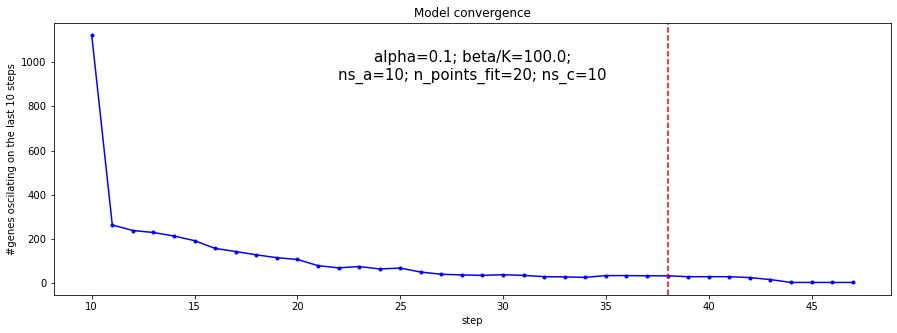

In [12]:
if plot_all:
    from method2 import plot_convergence
    #suffix = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",pv="+str(snr_pval)
    #save_plot = out_dir + basename +suffix + ".convergence.svg"
    save_plot = False
    plot_convergence(n_skipping_genes[0:], len(gene2Module_history)-sampling_steps-0,
                             alpha=alpha, beta_K=beta_K,
                             n_steps_averaged=n_steps_averaged,
                             n_points_fit = n_points_fit, 
                             n_steps_for_convergence = n_steps_for_convergence,
                             save_plot=save_plot)


In [13]:
consensus = get_consensus_modules(gene2Module_history[-sampling_steps:],verbose= True)



size(genes)	n_modules
0 		 797
1 		 82
2 		 680
3 		 4
11 		 1
16 		 1
87 		 1


Genes assigned to more than 1 module: 1


# 3) Define biclusters

In [14]:
from method2 import genesets2biclusters,  write_bic_table

In [15]:
exprs_np = exprs.loc[genes,:]
ints2g_names = exprs_np.index.values
ints2s_names = exprs_np.columns.values
exprs_np = exprs_np.values
exprs_sums = exprs_np.sum(axis=1)
exprs_sq_sums = np.square(exprs_np).sum(axis=1)
N = exprs.shape[1]
exprs_data = N, exprs_sums, exprs_sq_sums

In [16]:
filtered_bics = genesets2biclusters(consensus, exprs_np, exprs_data,ints2g_names,ints2s_names,
                        min_SNR = 0,min_n_samples=min_n_samples, min_n_genes=2,
                        verbose = verbose)

time:	Identified optimal sample sets for 1566 modules in 22.13 s.
Passed biclusters (>=26 genes, > 0 SNR): 687
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

3x112	1.445	B3GNT5 LY6D PPP1R14C
3x76	1.317	BRF2 LSM1 PROSC
11x63	1.192	CASC3 ERBB2 FBXL20 GRB7 MED1 MED24 ORMDL3 PSMD3 RPL19 STARD3 WIPF2
3x84	1.428	ALDH1L1 GLYAT KCNIP2
3x91	1.846	FOXC1 FOXL1 UGT8
87x97	0.651	ABCC4 ACTR3B ADD2 ALX3 APCDD1L ATOH7 BNC1 C12orf56 C1QL2 CCDC67 CCKBR CDH19 CDKN2A CEBPG CHRM3 CHST2 CPA4 CSMD1 CSN3 DDX43 DLX5 DLX6 DMRT1 DSG1 DYNC1I1 EN1 EPHB1 EPHB6 ETV6 FAM19A3 FBXL13 FOXG1 FSD1 GABBR2 GAL GJB6 GJB7 HORMAD1 HOXA13 IFRD1 IGF2BP2 INGX JPH3 KLHL34 LANCL3 LCT LPIN1 MAGEB1 MALL MAP2 MRAS OCA2 ODAM OGFRL1 OPRK1 PADI3 PAX6 PCBP3 PCDH8 PI3 PNLDC1 PNMA5 POU4F1 PRSS12 PRTFDC1 RASGEF1C RASGRF1 RGS20 RSF1 RTP3 SBSN SCHIP1 SLC10A4 SLC16A8 SLC26A9 SLC6A15 SLCO1A2 SLCO5A1 SOX8 STAC STK33 TMPRSS5 TUBB2B UCHL1 USP1 WBSCR17 ZIC5


In [17]:
result_file_name = out_dir+basename+suffix
write_bic_table(filtered_bics,
                result_file_name+".biclusters.tsv")


print("Total runtime:",round(time()-start_time,2),file = sys.stdout)
print(result_file_name)

Total runtime: 221.69
/home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-micro_13K.pv=0.05,direction=DOWN


# All steps in one function

In [18]:
import sys,os
import numpy as np
import pandas as pd
from time import time
import random
import argparse
import math
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def run_DESMOND(exprs_file, out_dir = "./",basename = False,
                min_n_samples = -1,
                alpha=1.0 ,beta_K=1.0, snr_pval = 0.05,
                max_n_steps= 100, n_steps_averaged = 10, n_steps_for_convergence = 10, n_points_fit=20,tol=0.1,
                load_binarized_exprs = True, plot_all=True, verbose = True, 
                seed= 42):
    
    from method2 import set_initial_conditions, sampling, get_consensus_modules
    from method2 import genesets2biclusters,  write_bic_table
    
    biclusters = {} # UP and DOWN
    start_time = time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 

    suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",pv="+str(snr_pval)
    if verbose:
        print("Will save output files to: %s*."% (out_dir + basename + suffix), file = sys.stdout)

    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

    # define minimal number of patients in a module
    if min_n_samples == -1:
        min_n_samples = int(max(5,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
    if verbose:
        print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)
    
    if load_binarized_exprs:
        # check if the files exist and create if necessary
        up = out_dir+"/"+basename+ ".pv="+str(snr_pval)+",direction=UP.bin_exprs.tsv"
        down = out_dir+"/"+basename+ ".pv="+str(snr_pval)+",direction=DOWN.bin_exprs.tsv"
        if not (os.path.exists(up) and os.path.exists(down)):
            load_binarized_exprs = False
            
    if not load_binarized_exprs:
        from method2 import rand_norm_splits, get_trend, GM_binarization
        
        #### Computing min_SNR(size) ###
        sizes,thresholds = rand_norm_splits(exprs.shape[1], snr_pval = snr_pval,seed=seed)
        get_min_snr = get_trend(sizes,thresholds, plot = plot_all)
    
        ####1. Binarization ####
        sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
        binarized_expressions = GM_binarization(exprs,get_min_snr,min_n_samples,verbose = verbose, 
                                            plot=False, plot_SNR_thr= 3.0, show_fits = sele_genes,seed = seed)
        # save binarized expressions
        sample_names = exprs.columns
        for d in ["UP","DOWN"]:
            df = binarized_expressions[d]
            df.index = sample_names
            fname = out_dir+"/"+basename+ ".pv="+str(snr_pval)+",direction="+d +".bin_exprs.tsv"
            print("Binarized gene expressions are saved to",fname,file = sys.stdout)
            df.to_csv(fname, sep ="\t")

    else:
        # load binarized expressions from files
        binarized_expressions = {}

        for d in ["UP","DOWN"]:
            fname = out_dir+"/"+basename+ ".pv="+str(snr_pval)+",direction="+d +".bin_exprs.tsv"
            print("Uses binarized gene expressions from",fname,file = sys.stdout)
            df = pd.read_csv(fname, sep ="\t",index_col=0)
            df.index = range(0,df.shape[0])
            binarized_expressions[d] = df

    ### 2. Edge clustering ###
    
    # simplifying probability calculations
    N = exprs.shape[1]
    max_log_float = np.log(np.finfo(np.float64).max)
    n_exp_orders = 7 # ~1000 times 
    p0 = N*np.log(0.5)+np.log(beta_K)
    match_score = np.log((alpha*0.5+1)/(alpha))
    mismatch_score = np.log((alpha*0.5+0)/alpha)
    bK_1 = math.log(1+beta_K)
    
    i = 0
    for direction in ["UP","DOWN"]:
        t1 = time()
        exprs_bin = binarized_expressions[direction]
        genes = exprs_bin.columns.values
        # setting initial model state
        print("Searching for %s-regulated biclusters ..."%direction)
        moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = verbose)
        K = len(moduleSizes)
        N = gene2Samples.shape[1]
        if verbose:
            print("\t\tLP matrix memory usage: {:.2f}M".format(LP.nbytes/(1024*1024)),file = sys.stdout)

        # sampling
        t0 = time()
        gene2Module_history,sampling_steps,n_skipping_genes = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score, bK_1, alpha, beta_K, 
                                                                          max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, tol = tol, 
                                                                          n_steps_for_convergence = n_steps_for_convergence, verbose=verbose)
        print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time()-t0,2)), file = sys.stdout)

        # plot the number of oscilating genes per step
        if plot_all:
            from method2 import plot_convergence
            suffix = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",pv="+str(snr_pval)
            save_plot = out_dir + basename +suffix + ".convergence.svg"

            plot_convergence(n_skipping_genes[0:], len(gene2Module_history)-sampling_steps-0,
                                     alpha=alpha, beta_K=beta_K,
                                     n_steps_averaged=n_steps_averaged,
                                     n_points_fit = n_points_fit, 
                                     n_steps_for_convergence = n_steps_for_convergence,
                                     save_plot=save_plot)
        
        # take the last (n_points_fit+n_steps_for_convergence) steps modules:
        # and get consensus edge-to-module membership
        consensus = get_consensus_modules(gene2Module_history[-sampling_steps:],verbose= True)
        
        #### 3. Define biclusters and merge modules  ####
        exprs_np = exprs.loc[genes,:]
        ints2g_names = exprs_np.index.values
        ints2s_names = exprs_np.columns.values
        exprs_np = exprs_np.values
        exprs_sums = exprs_np.sum(axis=1)
        exprs_sq_sums = np.square(exprs_np).sum(axis=1)
        N = exprs.shape[1]
        exprs_data = N, exprs_sums, exprs_sq_sums
        
        # Identify optimal patient sets for each module: split patients into two sets in a subspace of each module
        # Filter out bad biclusters with too few genes or samples, or with low SNR
        filtered_bics = genesets2biclusters(consensus, exprs_np, exprs_data,ints2g_names,ints2s_names,
                        min_SNR = 0,min_n_samples=min_n_samples, min_n_genes=2,
                        verbose = verbose)
        
         
        
        print("Runtime for %s-regulated biclusters: %s"%(direction, round(time()-t1,2)),file = sys.stdout)
        biclusters[direction] = filtered_bics
    
    # save results
    biclusters = biclusters["UP"] + biclusters["DOWN"]
    result_file_name = out_dir+basename+suffix
    write_bic_table(biclusters,result_file_name+".biclusters.tsv")
    print("Total runtime:",round(time()-start_time,2),file = sys.stdout)
        
    return biclusters

In [20]:
out_dir = os.getcwd()+"/results/"
alphas = [1.0, 0.1]
betas = [1, 100]

#### Run 0 alpha 1.0 beta 1 ###########################
Will save output files to: /home/olya/TUM/DESMOND/DESMOND2/results/TCGA-micro_13K.0.alpha=1.0,beta_K=1,pv=0.05*.
Mininal number of samples in a module: 26
Uses binarized gene expressions from /home/olya/TUM/DESMOND/DESMOND2/results//TCGA-micro_13K.0.pv=0.05,direction=UP.bin_exprs.tsv
Uses binarized gene expressions from /home/olya/TUM/DESMOND/DESMOND2/results//TCGA-micro_13K.0.pv=0.05,direction=DOWN.bin_exprs.tsv
Searching for UP-regulated biclusters ...
		KxN=1563x529
		p0= -366.67485851621103
	 1000 genes processed in  3.8 s
time:	Initial state created in 4.2 s.
		LP matrix memory usage: 18.64M
step 1
1000 		genes processed in 11.0 s runtime...
	step  1 16.1 s
step 2
1000 		genes processed in 5.9 s runtime...
	step  2 9.4 s
step 3
1000 		genes processed in 5.0 s runtime...
	step  3 7.6 s
step 4
1000 		genes processed in 3.1 s runtime...
	step  4 5.4 s
step 5
1000 		genes processed in 3.0 s runtime...
	step  5 4.8 s
step 6
1000 	

Genes assigned to more than 1 module: 12



size(genes)	n_modules
0 		 959
1 		 130
2 		 464
3 		 21
4 		 5
5 		 4
6 		 1
7 		 4
9 		 1
16 		 1
26 		 1
32 		 1
47 		 1
69 		 1
70 		 1
156 		 1
time:	Identified optimal sample sets for 1596 modules in 18.35 s.
Passed biclusters (>=26 genes, > 0 SNR): 507
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

4x131	1.401	S100A7 S100A7A S100A8 S100A9
7x231	1.159	BATF2 IFI44 OAS2 OASL RTP4 STAT1 XAF1
3x214	0.947	KCNE4 MRPS30 UGCG
7x201	0.981	ADCK5 BOP1 COMMD5 HSF1 SCRIB TOP1MT ZNF707
7x200	0.911	AP1G1 APRT DHODH HSBP1 KATNB1 TRAPPC2L VPS4A
5x213	1.188	HIST1H1C HIST1H1E HIST1H2AM HIST1H3H HIST1H4H
16x225	1.015	AURKB BLM CCNB2 CDCA7 CDCA8 CENPN CENPO CHEK1 GPSM2 KIF18A MCM4 MELK PDSS1 RFC4 STMN1 TTK
32x185	1.038	AIM2 BTLA CCR2 CD19 CD200R1 CD38 CD7 CD72 CD79A CTSW FCRL5 ICOS IFNG IGLL1 IL2RG IRF4 KLHL6 KLRD1 KRT81 LY9 PDCD1 PKHD1L1 PNOC PRF1 PTPN7 PTPRCAP SH2D1A SLA2 SLAMF1 TRAT1 XCL1 ZBTB32
3x221	0.721	CITED2 CNTN3 DNAH5
4x234	1.008	C1QTNF3 CORIN

Genes assigned to more than 1 module: 6


time:	Identified optimal sample sets for 1019 modules in 13.08 s.
Passed biclusters (>=26 genes, > 0 SNR): 373
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

6x139	0.912	ADRA2A GALNT10 PIP PRICKLE2 TGFB3 TMC5
9x243	1.362	HIST1H2BB HIST1H2BE HIST1H2BF HIST1H2BI HIST1H2BJ HIST1H2BL HIST1H2BM HIST1H2BO HIST3H2BB
3x210	1.52	ADH1A ADH1C FABP4
21x207	0.989	ANGPTL2 ASPN C14orf37 COL12A1 COL5A1 COPZ2 CPZ FBN1 GRP HTRA1 HTRA3 INHBA MMP11 NDN NOX4 OLFML1 P4HA3 PALLD SGCD ST6GAL2 WISP1
5x264	1.21	ITGAX LAIR1 LAPTM5 LILRB1 PARVG
3x203	0.879	ABHD14B MRPS27 RPS23
4x243	1.384	KLK5 KRT6A KRT6B KRT6C
3x152	1.624	SCGB1D1 SCGB1D2 SCGB2A2
3x216	0.865	FBXL3 GLTSCR2 RPS23
3x223	1.566	CIDEA LEP MRAP
126x109	1.018	ABCC8 ACADSB ACOT4 AGR2 AGR3 ANKRA2 ANXA9 AR ARSG ATP5G2 BBS1 BBS4 BTF3 C12orf10 C1orf64 C2orf15 C5orf30 C9orf116 CA12 CAMLG CAPN13 CCDC96 CIRBP CLSTN2 CMBL CPA3 CRIP1 CXXC5 DACH1 DALRD3 DAZAP2 DNAJC12 DNALI1 DYNLRB2 EAPP EPB41L5 ERBB3 ERBB4 ESR1 FAAH FA

Genes assigned to more than 1 module: 9



size(genes)	n_modules
0 		 953
1 		 112
2 		 475
3 		 21
4 		 7
5 		 4
6 		 1
8 		 1
9 		 1
12 		 1
21 		 1
26 		 1
34 		 1
38 		 1
54 		 1
73 		 1
147 		 1
time:	Identified optimal sample sets for 1583 modules in 19.29 s.
Passed biclusters (>=26 genes, > 0 SNR): 518
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

147x99	0.629	ABCC4 ABCD1 ACTR3B ADCYAP1 ADD2 ALX3 ANKS6 APCDD1L AQP6 ARNTL2 ATOH7 B3GAT1 BNC1 C11orf16 C12orf56 C1QL2 C8orf46 CALCB CCDC67 CCKBR CDH19 CDK6 CDKN2A CEBPG CHRM3 CHST2 CHST4 CIB2 CIB4 CLPS CPA4 CSN3 CSTA DDX43 DLX5 DLX6 DMRT1 DMRTA1 DSG1 DYNC1I1 ELAVL2 EN1 EPHB6 ETS1 ETV6 FABP5 FAM19A3 FAM58A FBXL13 FOLR1 FOXG1 FSD1 GABBR2 GAL GINS4 GJB3 GJB6 GNG4 GPI GPR161 GPRC5B GSTA3 GSTA5 HORMAD1 IGF2BP2 IL12A INGX KCNB1 KHDRBS3 KIRREL2 KLHL34 KRT83 KRT86 LANCL3 LCT LPIN1 MAGEB1 MALL MAP2 MAP7D2 MAPK4 MSLN NKX2-5 NRTN OCA2 ODAM OGDHL OGFRL1 OPRK1 PART1 PAX6 PCBP3 PCDH8 PCDHB6 PCYT2 PEG3 PGBD5 PI3 PITPNM2 PLCG2 PNMA5 POLD1 POU4F1 

Genes assigned to more than 1 module: 5



size(genes)	n_modules
0 		 561
1 		 97
2 		 355
3 		 7
4 		 1
5 		 1
7 		 1
9 		 1
10 		 1
24 		 1
30 		 1
121 		 1
time:	Identified optimal sample sets for 1028 modules in 12.39 s.
Passed biclusters (>=26 genes, > 0 SNR): 370
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

9x243	1.362	HIST1H2BB HIST1H2BE HIST1H2BF HIST1H2BI HIST1H2BJ HIST1H2BL HIST1H2BM HIST1H2BO HIST3H2BB
3x256	0.876	CNIH3 FAM26E MICAL2
3x210	1.52	ADH1A ADH1C FABP4
4x243	1.384	KLK5 KRT6A KRT6B KRT6C
3x152	1.624	SCGB1D1 SCGB1D2 SCGB2A2
3x223	1.566	CIDEA LEP MRAP
7x145	0.867	ADRA2A CPA3 GALNT10 OGN PIP PRICKLE2 TGFB3
3x221	0.732	CNIH3 FMO1 TMEM130
121x108	1.045	ABCC8 ACADSB ACOT4 AGR2 AGR3 ANKRA2 ANXA9 AR ARSG ATP5G2 BBS1 BBS4 BTF3 C12orf10 C1orf64 C2orf15 C5orf30 C9orf116 CA12 CAMLG CAPN13 CCDC96 CIRBP CLSTN2 CMBL CRIP1 CXXC5 DACH1 DALRD3 DAZAP2 DNAJC12 DNALI1 DYNLRB2 EAPP EPB41L5 ERBB3 ERBB4 ESR1 FAAH FAM110C FBP1 FBXL5 FOXA1 FYCO1 GAMT GATA3 GFRA1 GOLGA1 GPRC5C HDAC11 HP

Genes assigned to more than 1 module: 1


time:	Identified optimal sample sets for 1566 modules in 21.82 s.
Passed biclusters (>=26 genes, > 0 SNR): 690
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 0

4x88	1.342	ALDH1L1 CPA1 GLYAT KCNIP2
3x124	1.628	ROPN1 ROPN1B SOX10
3x76	1.317	BRF2 LSM1 PROSC
11x63	1.192	CASC3 ERBB2 FBXL20 GRB7 MED1 MED24 ORMDL3 PSMD3 RPL19 STARD3 WIPF2
3x105	1.562	CNTD2 CYP2A6 CYP2A7
99x97	0.539	ABCC4 ACTR3B ADD2 ADRB1 ALX3 APCDD1L ATOH7 BNC1 C12orf56 C1QL2 CCDC67 CCKBR CDH19 CDKN2A CEBPG CHGA CHRM3 CHST2 CNGB3 COX7B2 CPA4 CSMD1 CSN3 CST5 DDX43 DLX5 DLX6 DMRT1 DSG1 DYNC1I1 EN1 EPHB1 EPHB6 ETV6 FAM19A3 FBXL13 FOXG1 FSD1 GABBR2 GJB6 GJB7 HORMAD1 HOXA13 HS3ST5 HTR2C IGF2BP2 INGX JPH3 KLHL34 LANCL3 LCT LGI1 LPIN1 MAGEB1 MAGEC1 MALL MAP2 MRAS OCA2 ODAM OGFRL1 OPRK1 PADI3 PAGE2 PAGE2B PAX6 PCBP3 PCDH8 PI3 PNLDC1 PNMA5 POU4F1 PRKACB PRSS12 PRTFDC1 RASGEF1C RASGRF1 RGS20 RSF1 RTP3 SBSN SCHIP1 SLC10A4 SLC16A8 SLC26A9 SLC6A15 SLCO1A2 SLCO5A1 SOX8 SSX1 STAC STK33 TMPRSS5 TU

KeyboardInterrupt: 

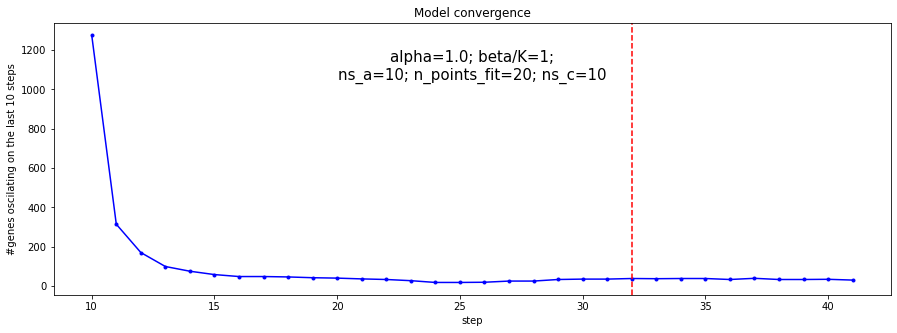

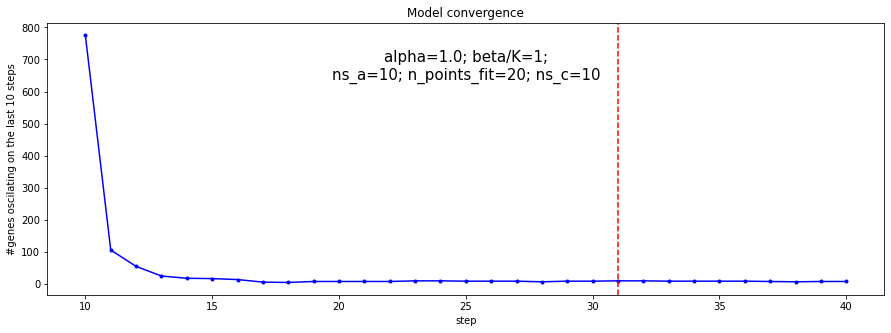

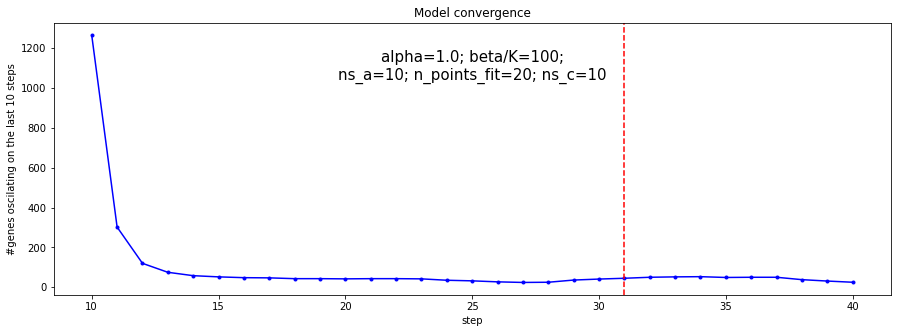

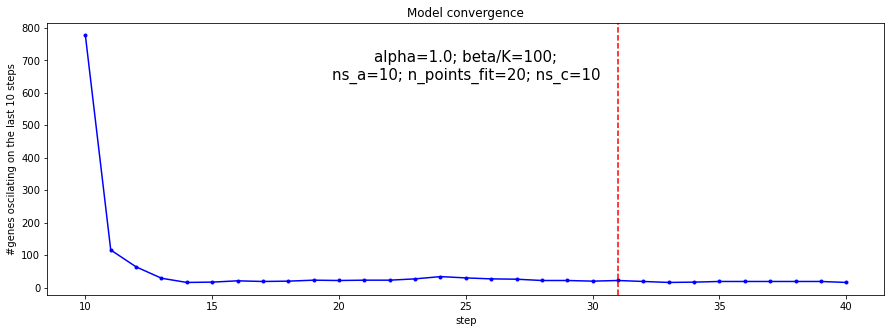

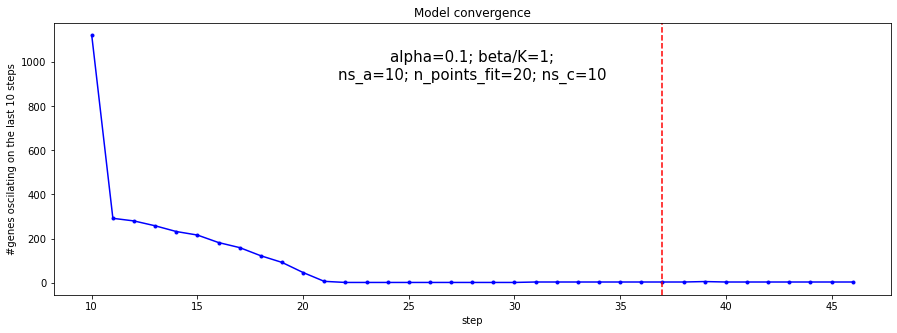

In [21]:
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"
for run in range(0,5):
    basename = "TCGA-micro_13K."+str(run)
    for a in alphas:
        for b in betas:
            print("#### Run",run, "alpha",a,"beta",b,"###########################")
            bics = run_DESMOND(exprs_file, alpha=a, beta_K=b, snr_pval = 0.05,
                           out_dir = out_dir,basename = basename,
                           plot_all=True, verbose = True)
        

# All tumors

In [ ]:
# METABRIC
exprs_file = "../datasets/METABRIC_1904_23K.nolog2_exprs_z.tsv"

for run in range(1,5):
    basename = "METABRIC_1904."+str(run)
    for a in alphas:
        for b in betas:
            bics = run_DESMOND(exprs_file, alpha=a, beta_K=b, snr_pval = 0.005,
                           out_dir = out_dir,basename = basename,
                           plot_all=True, verbose = True)


In [ ]:
# all tumors from TCGA
exprs_file = "../datasets/TCGA-BRCA_945.Xena.log2RSEM_norm_z.24K_genes.tsv"

for run in range(1,5):
    basename = "TCGA-BRCA_945."+str(run)
    for a in alphas:
        for b in betas:
            bics = run_DESMOND(exprs_file, alpha=a, beta_K=b, snr_pval = 0.005,
                           out_dir = out_dir,basename = basename,
                           plot_all=True, verbose = True)
